<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Machine-Learning-and-Deep-Learning-Projects/blob/main/transforming%20date%20format%20%5Bneural%20machine%20translation%20using%20attention%20model%5D/transforming_date_format_%5Bneural_machine_translation_using_attention_model%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transforming Date Format [Neural Machine Translation using Attention Model]**



We will build a Neural Machine Translation (NMT) model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25"). We will do this using an attention model which is one of the most sophisticated sequence-to-sequence models. 



* The model we will build here can be used to translate from one language to another. However, language translation requires massive datasets and usually takes days of training on GPUs. 
* To give a place to experiment with these models without using massive datasets, we will perform a simpler "date translation" task. 
* The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*). The network will translate them into standardized machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 


In [ ]:
pip install Faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.5 MB/s 


In [ ]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K

import numpy as np
import tensorflow as tf
import random
from faker import Faker
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt

In [ ]:
# helper function

def load_date():
# Loads some fake dates and returns: tuple containing human readable string, machine readable string and date object
    fake = Faker()
    
    LOCALES = ['en_US']  # change this for working with another language

    # Define format of the data we would like to generate
    FORMATS = ['short',
               'medium',
               'long',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'd MMM YYY', 
               'd MMMM YYY',
               'dd MMM YYY',
               'd MMM, YYY',
               'd MMMM, YYY',
               'dd, MMM YYY',
               'd MM YY',
               'd MMMM YYY',
               'MMMM d YYY',
               'MMMM d, YYY',
               'dd.MM.YY']

   
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US')  # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()       
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt



def load_dataset(m):
    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    
    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

In [ ]:
def string_to_int(string, length, vocab):   
    # Arguments:
    # string -> input string, e.g. 'Wed 10 Jul 2007'
    # length -> the number of time steps we'd like, determines if the output will be padded or cut
    # vocab -> vocabulary, dictionary used to index every character of "string"   
    # Returns:
    # rep -> list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
   
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep

In [ ]:
def int_to_string(ints, inv_vocab):
    # Arguments:
    # ints -> list of integers representing indexes in the machine's vocabulary
    # inv_vocab -> dictionary mapping machine readable indexes to machine readable characters 
    
    # Returns: l -> list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    
    l = [inv_vocab[i] for i in ints]
    return l

In [ ]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

In [ ]:
def softmax(x, axis=1):
    # Arguments
    # x : Tensor.
    # axis: Integer, axis along which the softmax normalization is applied.
    # Returns: Tensor, output of softmax transformation.
    # Raises: ValueError: In case `dim(x) == 1`.

    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')




**Dataset**

We will train the model on a dataset of 10,000 human readable dates and their equivalent, standardized machine readable dates. 

In [ ]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [04:15<00:00, 39.07it/s]


In [ ]:
dataset[:10]

[('16 april 1999', '1999-04-16'),
 ('29 mar 1982', '1982-03-29'),
 ('friday may 5 2006', '2006-05-05'),
 ('saturday december 14 1991', '1991-12-14'),
 ('monday february 18 2019', '2019-02-18'),
 ('tuesday october 25 2005', '2005-10-25'),
 ('15 sep 1988', '1988-09-15'),
 ('15 oct 1992', '1992-10-15'),
 ('jul 23 1985', '1985-07-23'),
 ('26 09 89', '1989-09-26')]

- `dataset`: a list of tuples of (human readable date, machine readable date).
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index.  **Note**: These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. 
- We will set Tx=30. We assume Tx is the maximum length of the human readable date. If we get a longer input, we have to truncate it.
- We will set Ty=10. "YYYY-MM-DD" is 10 characters long.

In [ ]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print(f"X.shape: {X.shape}")
print(f"Y.shape: {Y.shape}")
print(f"Xoh.shape: {Xoh.shape}")
print(f"Yoh.shape: {Yoh.shape}")

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


We now have:
- `X`: a processed version of the human readable dates in the training set. Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`. Each date is padded to ensure a length of $T_x$ using a special character (< pad >). `X.shape = (m, Tx)` where m is the number of training examples in a batch.
- `Y`: a processed version of the machine readable dates in the training set. Each character is replaced by the index (integer) it is mapped to in `machine_vocab`. 
`Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`. Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1 and the remaining positions are 0. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`. Each index in `Y` is converted to the one-hot representation. `Yoh.shape = (m, Ty, len(machine_vocab))`.  `len(machine_vocab) = 11` since there are 10 numeric digits (0 to 9) and the `-` symbol.

In [ ]:
# examples of preprocessed training examples

index = 0
print(f"Source date: {dataset[index][0]}")
print(f"Target date: {dataset[index][1]}")
print()
print(f"Source after preprocessing (indices): {X[index]}")
print(f"Target after preprocessing (indices): {Y[index]}")
print()
print(f"Source after preprocessing (one-hot): {Xoh[index]}")
print(f"Target after preprocessing (one-hot): {Yoh[index]}")

Source date: 16 april 1999
Target date: 1999-04-16

Source after preprocessing (indices): [ 4  9  0 13 27 28 21 23  0  4 12 12 12 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10 10  0  1  5  0  2  7]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


**Neural Machine Translation with Attention**

* If we have to translate a book's paragraph from French to English, we will not read the whole paragraph then close the book and translate. 
* Even during the translation process, we will read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English we are writing down. 
* The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 


We will use a LSTM instead of a basic RNN. So the LSTM has both the hidden state $s^{\langle t\rangle}$ and the cell state $c^{\langle t\rangle}$. 

#### Each time step does not use predictions from the previous time step
* Unlike text generation examples, in this model, the post-attention LSTM at time $t$ does not take the previous time step's prediction $y^{\langle t-1 \rangle}$ as input.
* The post-attention LSTM at time 't' only takes the hidden state $s^{\langle t\rangle}$ and cell state $c^{\langle t\rangle}$ as input. 
* We have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

#### Concatenation of hidden states from the forward and backward pre-attention LSTMs
- $\overrightarrow{a}^{\langle t \rangle}$: hidden state of the forward-direction, pre-attention LSTM.
- $\overleftarrow{a}^{\langle t \rangle}$: hidden state of the backward-direction, pre-attention LSTM.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: the concatenation of the activations of both the forward-direction $\overrightarrow{a}^{\langle t \rangle}$ and backward-directions $\overleftarrow{a}^{\langle t \rangle}$ of the pre-attention Bi-LSTM. 

#### Computing "energies" $e^{\langle t, t' \rangle}$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$
 The definition of "e" as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
  - "e" is called the "energies" variable.
  - $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
  - $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM.
  - $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$.
  - $e^{\langle t, t' \rangle}$ is then used when computing the attention $\alpha^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$.
 

#### Implementation Details
   
We will start by implementing two functions: `one_step_attention()` and `model()`.

#### one_step_attention
The inputs to the one_step_attention at time step $t$ are:
  - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: all hidden states of the pre-attention Bi-LSTM.
  - $s^{<t-1>}$: the previous hidden state of the post-attention LSTM. 

one_step_attention computes:
  - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: the attention weights.
  - $context^{ \langle t \rangle }$: the context vector:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}$$ 


We are calling the context $context^{\langle t \rangle}$. This is to avoid confusion with the post-attention LSTM's internal memory cell variable which is also denoted $c^{\langle t \rangle}$. 


**Implementtion of `one_step_attention()`** 

* The function `model()` will call the layers in `one_step_attention()` $T_y$ times using a for-loop.
* It is important that all $T_y$ copies have the same weights. 
    * It should not reinitialize the weights every time. 
    * In other words, all $T_y$ steps should have shared weights. 
* Here's how we can implement layers with shareable weights in Keras:
    1. Defining the layer objects in a variable scope that is outside of the `one_step_attention` function.  For example, defining the objects as global variables would work.
        - Defining these variables inside the scope of the function `model` would technically work, since `model` will then call the `one_step_attention` function.   
    2. Calling these objects when propagating the input.
* We have defined the layers we need as global variables. 
    * Running the following cells to create them. 

* Keras documentation to learn more about these layers.  The layers are functions.  Below are examples of how to call these functions.
    * [RepeatVector()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)
```Python
var_repeated = repeat_layer(var1)
```
    * [Concatenate()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)   
```Python
concatenated_vars = concatenate_layer([var1,var2,var3])
```
    * [Dense()](https://keras.io/layers/core/#dense)  
```Python
var_out = dense_layer(var_in)
```
    * [Activation()](https://keras.io/layers/core/#activation)  
```Python
activation = activation_layer(var_in)  
```
    * [Dot()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)  
```Python
dot_product = dot_layer([var1,var2])
```

In [ ]:
# Defined shared layers as global variables

repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') 
dotor = Dot(axes = 1)

In [ ]:
# one step attention

def one_step_attention(a, s_prev):

    # Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    # "alphas" and the hidden states "a" of the Bi-LSTM.
    
    # Arguments:
    # a -> hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    # s_prev -> previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    # Returns:
    # context -> context vector, input of the next (post-attention) LSTM cell
    

    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) for concatenating it with all hidden states "a" 
    s_prev = repeator(s_prev)
    
    # Use concatenator to concatenate a and s_prev on the last axis 
    concat = concatenator([a, s_prev])
   
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. 
    e = densor1(concat)
    
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. 
    energies = densor2(e)
    
    # Use "activator" on "energies" to compute the attention weights "alphas" 
    alphas = activator(energies)
    
    # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell 
    context = dotor([alphas, a])
    
    return context

**Implementation of `modelf()`** 

* `modelf` first runs the input through a Bi-LSTM to get $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Then, `modelf` calls `one_step_attention()` $T_y$ times using a `for` loop.  At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat{y}^{<t>}$.
    
We have defined global layers that will share weights to be used in `modelf()`.

In [ ]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# this is the post attention LSTM cell  
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # do not modify this global variable.
output_layer = Dense(len(machine_vocab), activation=softmax)

Now we can use these layers $T_y$ times in a `for` loop to generate the outputs and their parameters will not be reinitialized. We will have to carry out the following steps: 

1. Propagate the input `X` into a bi-directional LSTM.
    * [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) 
    * [LSTM](https://keras.io/layers/recurrent/#lstm)
    * Remember that we want the LSTM to return a full sequence instead of just the last hidden state.  
    
Sample code:

```Python
sequence_of_hidden_states = Bidirectional(LSTM(units=..., return_sequences=...))(the_input_X)
```
    
2. Iterate for $t = 0, \cdots, T_y-1$: 
    
- Call `one_step_attention()`, passing in the sequence of hidden states $[a^{\langle 1 \rangle},a^{\langle 2 \rangle}, ..., a^{ \langle T_x \rangle}]$ from the pre-attention bi-directional LSTM and the previous hidden state $s^{<t-1>}$ from the post-attention LSTM to calculate the context vector $context^{<t>}$.
- Give $context^{<t>}$ to the post-attention LSTM cell. 
     - Remember to pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM 

     - This outputs the new hidden state 
  $s^{<t>}$ 
and the new cell state $c^{<t>}$.   

        Sample code:
        ```Python
        next_hidden_state, _ , next_cell_state = 
            post_activation_LSTM_cell(inputs=..., initial_state=[prev_hidden_state, prev_cell_state])
        ```   
        The layer is actually the "post attention LSTM cell".  

     - Apply a dense, softmax layer to
  $s^{<t>}$, get the output.  
        Sample code:
        ```Python
        output = output_layer(inputs=...)
        ```
     - Save the output by adding it to the list of outputs.

3. Create Keras model instance.

- It should have three inputs:
    - `X`, the one-hot encoded inputs to the model of shape ($T_{x}, humanVocabSize)$
    - $s^{\langle 0 \rangle}$, the initial hidden state of the post-attention LSTM
    - $c^{\langle 0 \rangle}$, the initial cell state of the post-attention LSTM
- The output is the list of outputs.  
    Sample code
    ```Python
    model = Model(inputs=[...,...,...], outputs=...)
    ```

In [ ]:
# model

def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
 
    # Arguments:
    # Tx -> length of the input sequence
    # Ty -> length of the output sequence
    # n_a -> hidden state size of the Bi-LSTM
    # n_s -> hidden state size of the post-attention LSTM
    # human_vocab_size -> size of the python dictionary "human_vocab"
    # machine_vocab_size -> size of the python dictionary "machine_vocab"

    # Returns:
    # model -> Keras model instance
  
    
    # Define the inputs of model with a shape (Tx,)  
    X = Input(shape=(Tx, human_vocab_size))

    # Define s0 (initial hidden state) and c0 (initial cell state) for the decoder LSTM with shape (n_s,)
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Step 1: Define pre-attention Bi-LSTM
    a = Bidirectional(LSTM(n_a, return_sequences = True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector. initial_state = [hidden state, cell state]
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM 
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list 
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs 
    model = Model([X, s0, c0], outputs)
    
    return model

In [ ]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 64)       17920       ['input_1[0][0]']                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 30, 64)       0           ['s0[0][0]',                     
                                                                  'lstm[0][0]',               

In [ ]:
# compile the model

opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)  
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

**Define Inputs and Outputs and Fit The Model**

The last step is to define all our inputs and outputs to fit the model:
- We have input `Xoh` of shape $(m = 10000, T_x = 30, human\_vocab=37)$ containing the training examples.
- We need to create `s0` and `c0` to initialize our `post_attention_LSTM_cell` with zeros.
- Given the `model()` , we need the "outputs" to be a list of 10 elements of shape (m, T_y). 
    - The list `outputs[i][0], ..., outputs[i][Ty]` represents the true labels (characters) corresponding to the $i^{th}$ training example (`Xoh[i]`). 
    - `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [ ]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [ ]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

100/100 [==============================] - 30s 78ms/step - loss: 16.2924 - dense_2_loss: 1.2584 - dense_2_1_loss: 1.0106 - dense_2_2_loss: 1.7201 - dense_2_3_loss: 2.6522 - dense_2_4_loss: 0.7556 - dense_2_5_loss: 1.2094 - dense_2_6_loss: 2.6753 - dense_2_7_loss: 0.8661 - dense_2_8_loss: 1.6694 - dense_2_9_loss: 2.4753 - dense_2_accuracy: 0.4803 - dense_2_1_accuracy: 0.7080 - dense_2_2_accuracy: 0.3094 - dense_2_3_accuracy: 0.1024 - dense_2_4_accuracy: 0.9037 - dense_2_5_accuracy: 0.3724 - dense_2_6_accuracy: 0.0643 - dense_2_7_accuracy: 0.9219 - dense_2_8_accuracy: 0.2634 - dense_2_9_accuracy: 0.1175


This model already has been run for longer and saved the weights. Loading pre-trained weights. (By training a model for several minutes, we should be able to obtain a model of similar accuracy but loading pre-trained model will save time.)

In [ ]:
model.load_weights("/content/model.h5")

In [ ]:
# trying on new examples

EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print(f"source: {example}")
    print(f"output: {''.join(output)}\n")

source: 3 May 1979
output: 1979-05-33

source: 5 April 09
output: 2009-04-05

source: 21th of August 2016
output: 2016-08-20

source: Tue 10 Jul 2007
output: 2007-07-10

source: Saturday May 9 2018
output: 2018-05-09

source: March 3 2001
output: 2001-03-03

source: March 3rd 2001
output: 2001-03-03

source: 1 March 2001
output: 2001-03-01



**Visualizing Attention** 

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (such as the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what each part of the output is looking at which part of the input.



**Getting Attention Weights From The Network**

Lets now visualize the attention values in our network. We'll propagate an example through the network then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 64)       17920       ['input_1[0][0]']                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 30, 64)       0           ['s0[0][0]',                     
                                                                  'lstm[0][0]',               

By navigating through the output of `model.summary()` above. We can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Let's get the attention weights from this layer.

The function `attention_map()` pulls out the attention values from  model and plots them.



In [ ]:
# helper function

def plot_attention_map(modelx, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 7):

    attention_map = np.zeros((10, 30))
    layer = modelx.get_layer('attention_weights')

    Ty, Tx = attention_map.shape
    
    human_vocab_size = 37
    
    # Well, this is cumbersome but this version of tensorflow-keras has a bug that affects the reuse of layers in a model with the 
    # functional API. So, we have to recreate the model based on the functional components and connect them one by one. Ideally it 
    # can be done simply like this:
    # layer = modelx.layers[num]
    # f = Model(modelx.inputs, [layer.get_output_at(t) for t in range(Ty)])
    
    
    X = modelx.inputs[0] 
    s0 = modelx.inputs[1] 
    c0 = modelx.inputs[2] 
    s = s0
    c = s0
    
    a = modelx.layers[2](X)  
    outputs = []

    for t in range(Ty):
        s_prev = s
        s_prev = modelx.layers[3](s_prev)
        concat = modelx.layers[4]([a, s_prev]) 
        e = modelx.layers[5](concat) 
        energies = modelx.layers[6](e) 
        alphas = modelx.layers[7](energies) 
        context = modelx.layers[8]([alphas, a])
        # Don't forget to pass: initial_state = [hidden state, cell state] 
        s, _, c = modelx.layers[10](context, initial_state = [s, c]) 
        outputs.append(energies)

    f = Model(inputs=[X, s0, c0], outputs = outputs)
    

    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    
    r = f([encoded, s0, c0])
        
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]

    # Normalize attention map
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]

    prediction = modelx.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

<Figure size 432x288 with 0 Axes>

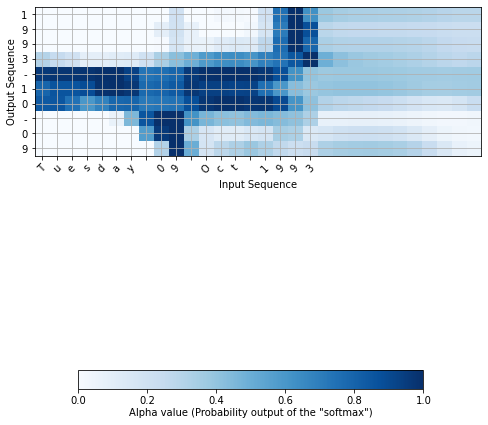

In [ ]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

On the generated plot we can observe the values of the attention weights for each character of the predicted output. By examining this plot we can check that the places where the network is paying attention that makes sense to us.

